In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as colormaps

from importlib import reload

import environment as Env
import ray as Ray
import simulation as Sim

In [2]:
reload(Env)

# floor = lambda x: -550 * np.ones_like(x)
# floor = lambda x: -500 * np.sin(0.001 * x) - 750
# floor = lambda x: -5 * np.sin(0.01 * x) - 750
# floor = lambda x: -0.27 * x - 500
floor = lambda x: np.maximum(-1 * np.exp(0.0005 * x) - 500, -1500 + 0.02*x)

ceiling = lambda x: 0 * np.ones_like(x)

env = Env.Environment2D(
    floor=floor,
    ceiling=ceiling
)

In [3]:
# Source setup
source = np.array([0., 0.])
angle = -0.5
freq = 100

In [4]:
# reload(Ray)

# ray = Ray.Ray2D (env, source, freq, angle)
# ray.propagate()  # verbose=True)

In [5]:
# plt.figure(figsize=(50, 2))
# plt.plot(ray.XZ[1:,0], ray.dL)
# plt.xlim((0, 50000))
# plt.xlabel('x [m]')
# plt.ylabel('dL [m]')
# plt.title('Integration segment length over the ray\'s trajectory')
# plt.show()

# plt.figure(figsize=(50, 2))
# plt.plot(ray.XZ[:,0], ray.A_dB)
# plt.xlim((0, 50000))
# plt.xlabel('x [m]')
# plt.ylabel('A [dB]')
# plt.title('Sound absorption over the ray\'s trajectory')
# plt.show()

# plt.figure(figsize=(50, 2))
# plt.plot(ray.XZ[:,0], ray.XZ[:,1])
# plt.plot(ray.XZ[:,0], ceiling(ray.XZ[:,0]), c='red')
# plt.plot(ray.XZ[:,0], floor(ray.XZ[:,0]), c='red')
# # plt.xlim((env.range_min.x, env.range_max.x))
# # plt.ylim((env.range_min.z, env.range_max.z))
# plt.xlim((0, 50000))
# plt.ylim((-2000, 0))
# plt.xlabel('x [m]')
# plt.ylabel('z [m]')
# plt.title('Ray trajectory')
# plt.show()

# plt.figure(figsize=(50, 2))
# plt.scatter(ray.XZ[:,0], ray.XZ[:,1], c=ray.A_dB, cmap=colormaps.Blues_r)
# plt.plot(ray.XZ[:,0], ceiling(ray.XZ[:,0]), c='red')
# plt.plot(ray.XZ[:,0], floor(ray.XZ[:,0]), c='red')
# # plt.xlim((env.range_min.x, env.range_max.x))
# # plt.ylim((env.range_min.z, env.range_max.z))
# plt.xlim((0, 50000))
# plt.ylim((-2000, 0))
# plt.xlabel('x [m]')
# plt.ylabel('z [m]')
# plt.title('Ray trajectory with intensity (log scale)')
# plt.show()

In [7]:
reload(Ray)
reload(Env)
reload(Sim)

sim = Sim.Simulation2D (env)
# sim.add_rays (source, freq, -0.5, -0.6, -0.7, -0.8, -0.9, 1., dx_max=10, dz_max=10, n_rebounds_max=4, backprop=True)  # , verbose=True)
# sim.add_rays (source, freq, -0.5, -0.5001, -0.5002, -0.5003, -0.5004, dx_max=10, dz_max=10, backprop=False)  # , verbose=True)
# sim.add_rays (source, freq, -0.5, -0.500001, -0.500002, -0.500003, -0.50004, dx_max=10, dz_max=10, backprop=False)  # , verbose=True)

# sim.add_rays (
#     source,
#     freq,
#     *[i/100 for i in range(-1, -100, -1)],  #-10)],
#     dx_max=10,
#     dz_max=10,
#     backprop=True,
#     # n_rebounds_max=4
# )

# sim.add_rays (
#     source,
#     freq,
#     *[i/100 for i in range(-1, -100, -1)],  #-10)],
#     dx_max=10,
#     dz_max=10,
#     backprop=True,
#     n_rebounds_max=4
# )

sim.add_rays (
    source,
    freq,
    *[i/250 for i in range(-1, -250, -1)],  #-10)],
    dx_max=10,
    dz_max=10,
    backprop=True,
    n_rebounds_max=4
)

In [8]:
stop_reasons = [ray.stop_reason for ray in sim.rays]
stop_reasons.sort()
stop_reasons_set = set(stop_reasons)
for sr in stop_reasons_set:
    n = stop_reasons.count(sr)
    print(f'{sr}: {n}')

max-rebounds: 249


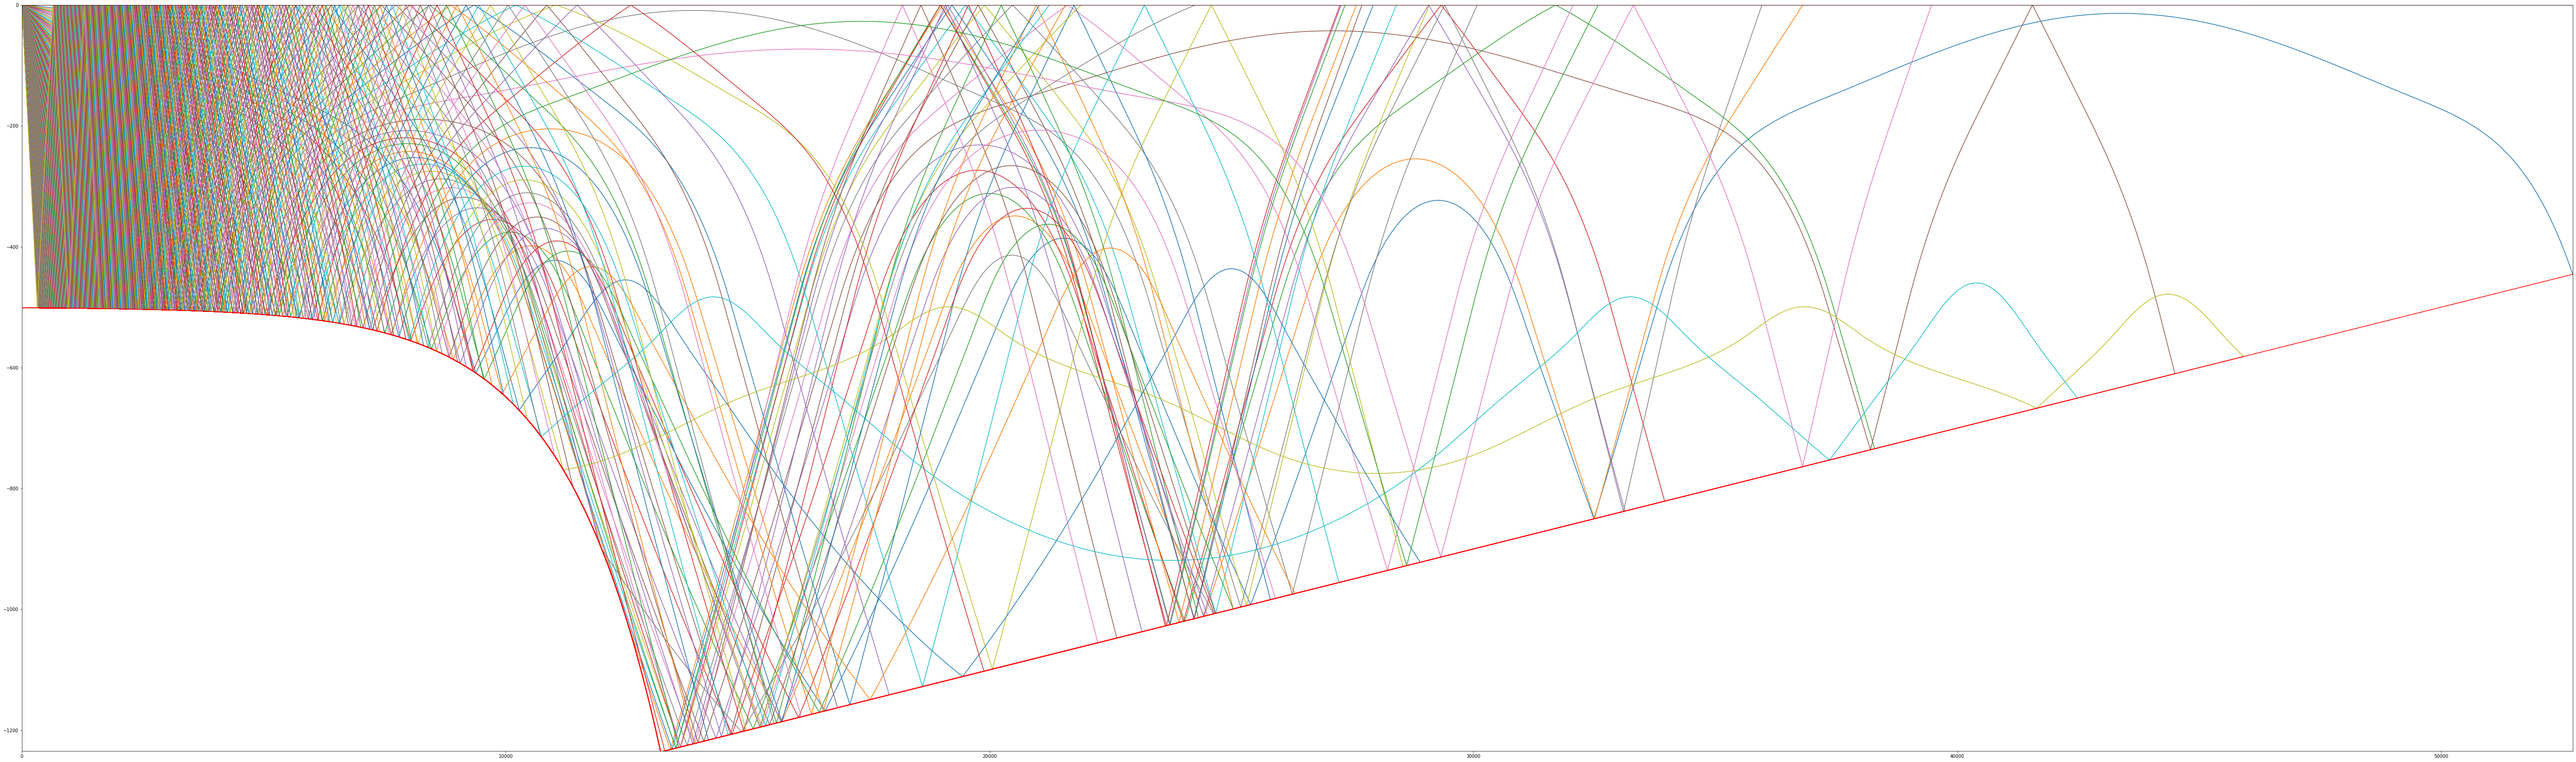

In [9]:
# plt.figure(figsize=(100, 4))
plt.figure(figsize=(100, 30))
for ray in sim.rays:
    plt.plot(ray.XZ[:,0], ray.XZ[:,1])
    plt.plot(ray.XZ[:,0], ceiling(ray.XZ[:,0]), c='red')
    plt.plot(ray.XZ[:,0], floor(ray.XZ[:,0]), c='red')
# plt.xlim((env.range_min.x, env.range_max.x))
# plt.ylim((env.range_min.z, env.range_max.z))
# plt.xlim((0, 50000))
# plt.ylim((-2000, 0))
# plt.ylim(-5000, 0)
plt.xlim((sim.range_min[0], sim.range_max[0]))
plt.ylim((sim.range_min[1], sim.range_max[1]))
plt.show()

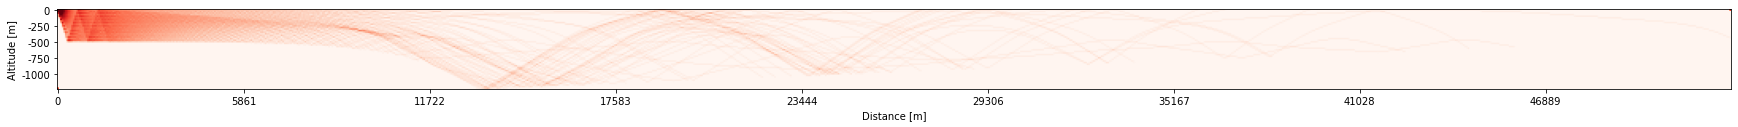

In [113]:
res = np.array([100, 50])  # resolution, in meters (must be less precise than the simulation's max dz and dx)
res = np.array([50, 25])
xdim, ydim = heatmap_shape = np.ceil(sim.size/res).astype(int)
heatmap_full = np.zeros(heatmap_shape)

for ray in sim.rays:
    rx = ray.XZ.copy().astype(int)
    rx = np.insert(rx, 0, sim.range_min, axis=0)
    rx = np.insert(rx, 0, sim.range_max, axis=0)

    x = rx[:, 0] // res[0]
    y = rx[:, 1] // -1 * res[1]

    heatmap, xedges, yedges = np.histogram2d(x, y, bins=heatmap_shape)
    heatmap_full += heatmap

# Process heatmap
cutoff = 150  # TODO: set cutoff
heatmap_full[heatmap_full > cutoff] = cutoff
heatmap_norm = heatmap_full / np.max(heatmap_full)
heatmap_plot = np.log(heatmap_norm + 1.)


# TODO: plot ground (convex assumption)
z_floor = sim.env.floor(np.arange(0, xdim, 1) * res[0])
z_width = np.arange(0, ydim, 1) * -1 * res[1]
floor_mask = (np.tile(z_width, (xdim, 1)).T < z_floor).T


plt.figure(figsize=(30, 10))

xticks_npoints = 10
yticks_npoints = 6
xticks_heatmap = np.linspace(0, xdim, xticks_npoints)
yticks_heatmap = np.linspace(0, ydim, yticks_npoints)
xticks_true = np.round(np.linspace(0, xdim, xticks_npoints) * res[0], 0) .astype(int)
yticks_true = np.round(np.linspace(0, ydim, yticks_npoints) * -1 * res[1], 0) .astype(int)
# TODO: Replace with clean arange

plt.xticks(xticks_heatmap, xticks_true)
plt.yticks(yticks_heatmap, yticks_true)
plt.xlabel('Distance [m]')
plt.ylabel('Altitude [m]')

plt.imshow(heatmap_plot.T)
# plt.imsave('heatmap.png', heatmap_plot.T)

In [107]:
import cv2

heatmap_log_norm = (heatmap_plot - np.min(heatmap_plot)) / np.max(heatmap_plot)
heatmap_norm_3ch = np.tile(heatmap_log_norm * 255, (3, 1, 1))
heatmap_norm_3ch = np.transpose(heatmap_norm_3ch, (2, 1, 0))

floor_overlay = np.transpose(np.tile(floor_mask * 255, (3, 1, 1)), (2, 1, 0)) * 0
# floor_overlay[:, :, 1:] = 0
heatmap_norm_3ch += floor_overlay

cv2.imwrite('heatmap.jpg', heatmap_norm_3ch)
cv2.imwrite('floor.jpg', floor_mask.T*255)

True